<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/ISIC2017_new_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get Data

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import csv
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as app
seed = 1234
np.random.seed(seed)
fig=plt.figure()
FJoin = os.path.join

<Figure size 432x288 with 0 Axes>

In [3]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)

# Initial Data

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [4]:
def GetFiles(path):
    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list

def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name.replace(".jpg","_segmentation.png"))
    #print(mask_path)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    _,img_mask = cv2.threshold(img_mask,127,255,cv2.THRESH_BINARY)
    img_mask = img_mask/255.
    return img_mask


def build_data(path,mask_folder,csv_path,img_shapes):
  w,h = img_shapes
  imgs=[]
  masks=[]
  img_name=[]
  with open(csv_path, 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        img_name.append(row[0])
  for count,file in enumerate(img_name[1:601]):
        print(count)
        file+=".jpg"
        fullpath= os.path.join(path,file)
        msk=get_mask(file,mask_folder)
        msk=cv2.resize(msk,(w,h))
        masks.append(msk)
        image=cv2.imread(fullpath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image=image/127.5-1
        image=cv2.resize(image,(w,h))
        imgs.append(image)
        if count%200 == 0:
          plt.figure(count//200)
          plt.subplot(1,2,1).imshow(image,cmap='gray')
          plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
          plt.show()  
  imgs=np.asarray(imgs,dtype=np.float)
  masks=np.asarray(masks,dtype=np.float).reshape(-1,h,w,1)
  print("shape imgs: ",imgs.shape)
  print("shape masks: ",masks.shape)
  return imgs,masks

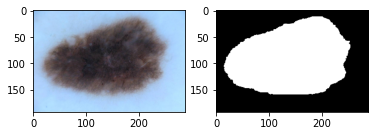

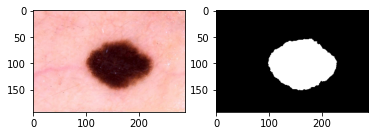

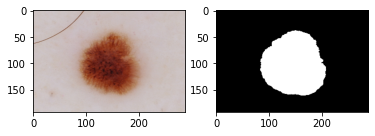

shape imgs:  (600, 192, 288, 3)
shape masks:  (600, 192, 288, 1)


In [5]:
w = 288
h = 192
folder_train = "/content/drive/My Drive/cuong_folder/ISIC-2017_Training_Data"
mask_train_folder = "/content/drive/My Drive/cuong_folder/ISIC-2017_Training_Part1_GroundTruth"
csv_train = '/content/drive/My Drive/cuong_folder/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv'

imgs,masks = build_data(folder_train,mask_train_folder, csv_train, (w,h))


In [6]:
masks=masks.reshape(masks.shape[0],masks.shape[1],masks.shape[2],1)
print(imgs.shape,masks.shape)

(600, 192, 288, 3) (600, 192, 288, 1)


In [7]:
np.random.seed(13)
index = np.random.permutation(imgs.shape[0])
img_dev=imgs[index[:100]]
mask_dev=masks[index[:100]]
imgs = imgs[index[100:]]
masks = masks[index[100:]]

In [8]:
class lr_scheduler(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))

#loss

In [9]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)
def gradientLoss2d(input):
    dH = K.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = K.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    dH = dH * dH
    dW = dW * dW
    loss = K.sum(dH) + K.sum(dW)
    return loss
def levelsetLoss(y_true, y_pred, ratio = 0.001):
    #print("go")
    outshape = y_pred.shape
    tarshape = y_true.shape
    multi = y_true*y_pred
    c_numerator = K.sum(multi, [1,2])
    c_denominator = K.sum(y_pred, [1,2])
    #print("outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape")
    #print(outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape)
    c = c_numerator/c_denominator
    #print("s",c.shape)
    c = K.reshape(c, (-1, 1, 1,outshape[3])) 
    #print("c.shape: ", c.shape)
    plevel = y_true - c
    #print("plevel: ", plevel)
    pLoss = plevel * plevel * y_pred
    lossL = K.mean(pLoss)
    #print("lossL: ", lossL)
    lossA = gradientLoss2d(y_pred) * ratio

    return lossL  + dice_coef_loss(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    print(y_true.shape)
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)
def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

# Data Augument

In [10]:
#from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

#attention gate

In [11]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)


    f = Activation('relu')(add([theta_x, phi_g]))


    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x

In [26]:
def heviside(x):
    return 1/2*(1+2/3.14159*tf.math.atan(x/0.1))

In [28]:
def unet(input_size = (192,288,3),classnum=2,pretrained_weights = None):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    merge6 = attention_up_and_concate(conv5,conv4)
    conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    merge7 = attention_up_and_concate(conv6,conv3)
    conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    merge8 = attention_up_and_concate(conv7,conv2)
    conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    merge9 = attention_up_and_concate(conv8,conv1)
    conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(1, 1, activation = "sigmoid")(conv9)

    model = Model(inputs = data, outputs = conv10)

    
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

In [27]:
input_shape = (h, w, 3)
model = unet(input_shape,2)
model.compile(optimizer = SGD(lr = 0.01, momentum = 0.9), loss = focal_tversky, metrics = ['accuracy',dice_coef])
checkpoint = ModelCheckpoint('weights_save/unet.{epoch:02d}_{val_dice_coef:.2f}.h5', monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
lr_decay = lr_scheduler()
callback_list = [checkpoint]
history = model.fit(train_generator, steps_per_epoch = imgs.shape[0]//4, epochs = 80, validation_data = (img_dev, mask_dev),callbacks=callback_list,verbose = 1)

Epoch 1/80
125/125 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8673 - dice_coef: 0.7179
Epoch 00001: val_dice_coef improved from -inf to 0.75033, saving model to weights_save/eff_unet.01_0.75.h5
125/125 [==============================] - 26s 211ms/step - loss: 0.2964 - accuracy: 0.8673 - dice_coef: 0.7179 - val_loss: 0.2247 - val_accuracy: 0.9123 - val_dice_coef: 0.7503
Epoch 2/80
125/125 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9146 - dice_coef: 0.8058
Epoch 00002: val_dice_coef improved from 0.75033 to 0.83581, saving model to weights_save/eff_unet.02_0.84.h5
125/125 [==============================] - 26s 207ms/step - loss: 0.2186 - accuracy: 0.9146 - dice_coef: 0.8058 - val_loss: 0.2109 - val_accuracy: 0.9405 - val_dice_coef: 0.8358
Epoch 3/80
125/125 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9223 - dice_coef: 0.8288
Epoch 00003: val_dice_coef improved from 0.83581 to 0.83596, saving model to we

KeyboardInterrupt: ignored

In [15]:
model.save_weights("weights_save/attention_unet.h5")

In [16]:
model.evaluate(img_dev,mask_dev)

4/4 [==============================] - 1s 172ms/step - loss: 0.1475 - accuracy: 0.9535 - dice_coef: 0.9020


[0.14745764434337616, 0.9534796476364136, 0.9019949436187744]

In [ ]:
mask_pred = model.predict(img_dev[:100])
mask_pred = mask_pred.astype("float64")

In [ ]:
loss = dice_coef_loss(mask_dev[:100],mask_pred)
loss2 = levelsetLoss(mask_dev[:100],mask_pred)

(100, 192, 288, 1)
(100, 192, 288, 1)


#visualize 

In [36]:
model = unet(input_shape,2)
model.load_weights("weights_save/attention_unet.h5")

In [41]:
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 192, 288, 3) 0                                            
__________________________________________________________________________________________________
lambda_207 (Lambda)             (None, 192, 288, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv2d_288 (Conv2D)             (None, 192, 288, 64) 1792        lambda_207[0][0]                 
__________________________________________________________________________________________________
lambda_208 (Lambda)             (None, 192, 288, 64) 0           conv2d_288[0][0]                 
______________________________________________________________________________________

In [43]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_288 (3, 3, 3, 64)
conv2d_289 (3, 3, 64, 64)
conv2d_290 (3, 3, 64, 128)
conv2d_291 (3, 3, 128, 128)
conv2d_292 (3, 3, 128, 256)
conv2d_293 (3, 3, 256, 256)
conv2d_294 (3, 3, 256, 512)
conv2d_295 (3, 3, 512, 512)
conv2d_296 (3, 3, 512, 1024)
conv2d_297 (3, 3, 1024, 1024)
conv2d_298 (1, 1, 512, 256)
conv2d_299 (1, 1, 1024, 256)
conv2d_300 (1, 1, 256, 1)
conv2d_301 (3, 3, 1536, 512)
conv2d_302 (3, 3, 512, 512)
conv2d_303 (1, 1, 256, 128)
conv2d_304 (1, 1, 512, 128)
conv2d_305 (1, 1, 128, 1)
conv2d_306 (3, 3, 768, 256)
conv2d_307 (3, 3, 256, 256)
conv2d_308 (1, 1, 128, 64)
conv2d_309 (1, 1, 256, 64)
conv2d_310 (1, 1, 64, 1)
conv2d_311 (3, 3, 384, 128)
conv2d_312 (3, 3, 128, 128)
conv2d_313 (1, 1, 64, 32)
conv2d_314 (1, 1, 128, 32)
conv2d_315 (1, 1, 32, 1)
conv2d_316 (3, 3, 192, 64)
conv2d_317 (3, 3, 64, 64)
conv2d_318 (3, 3, 64, 2)
conv2d_319 (1, 1, 2, 1)


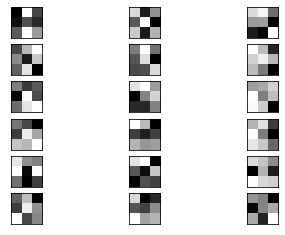

In [42]:
from matplotlib import pyplot
# load the model
# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

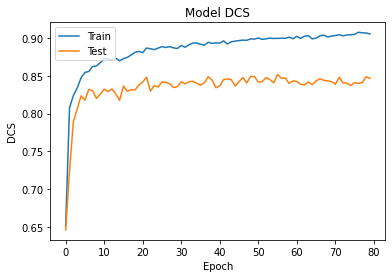

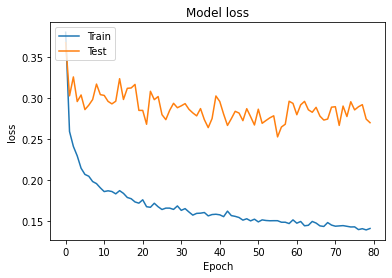

In [ ]:
#plt.figure(1)
#plt.subplot(121,aspect='auto')
y=history.history['val_dice_coef']
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model DCS')
plt.ylabel('DCS')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#plt.subplot(122,aspect='auto')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


#Evaluate

#Fit Generator


In [ ]:
import os

FJoin = os.path.join

def GetFiles(path):

    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list


files, dirs = GetFiles(os.path.expanduser("weights_save"))
for file in files:
    model.load_weights(file)
    print(model.evaluate(imgs,masks))


In [ ]:
plt.imshow(imgs[5])
plt.show()
plt.imshow(pred[5,:,:,0])
#plt.imshow(masks[5,:,:,0])

#build mat file

In [ ]:
import scipy.io as sio
path1="Matfile"
if not os.path.exists(path1):
            os.makedirs(path1)

for i in range(1,600):
  name1=img_name[i]
  matpath1= os.path.join(path1,name1)
  matpath1+=".mat"
  sio.savemat(matpath1, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})
  
path2="Matfile/Test"
if not os.path.exists(path2):
            os.makedirs(path2)
for i in range(n,leng):
  name2=img_name[i]
  matpath2= os.path.join(path2,name2)
  matpath2+=".mat"
  sio.savemat(matpath2, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})

In [ ]:
import shutil
shutil.make_archive('Matfile', 'zip',"Matfile")
